In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from sklearn.cluster import KMeans

rowsToCluster = pd.DataFrame()
startRampPath = 'data/BLM/start_ramp'

In [6]:
def getRowWithBlmMax(blmData):
    """
    Parameters
        blmData : DataFrame -- DataFrame loaded from the BLM data file, without timestamp column
    Returns
        DataFrame with row with the max BLM value in the provided data
    """
    
    blmMax = blmData.max() # Series of column num (i.e. BLM num) -> maximum value for that column
    blmMaxOverall = blmData.values.max() # max BLM value in the whole dataset
    rowIndexWithBlmMaxOverall = blmData.idxmax()[blmMax[blmMax == blmMaxOverall].index]
    rowWithBlmMaxOverall = blmData.loc[rowIndexWithBlmMaxOverall]
    
    assert rowWithBlmMaxOverall.max().max() == blmMaxOverall
    #TODO what if more than one row contains the same blmMaxOverall?
    assert len(rowWithBlmMaxOverall.index) == 1
    
    return rowWithBlmMaxOverall

In [3]:
# To confirm that fills have been loaded in chronological order
os.listdir(startRampPath)

['Fill_6953_start_ramp.txt',
 'Fill_6956_start_ramp.txt',
 'Fill_6960_start_ramp.txt',
 'Fill_6972_start_ramp.txt',
 'Fill_6980_start_ramp.txt',
 'Fill_6984_start_ramp.txt',
 'Fill_6993_start_ramp.txt',
 'Fill_6998_start_ramp.txt',
 'Fill_7012_start_ramp.txt',
 'Fill_7024_start_ramp.txt',
 'Fill_7061_start_ramp.txt',
 'Fill_7065_start_ramp.txt',
 'Fill_7073_start_ramp.txt',
 'Fill_7090_start_ramp.txt',
 'Fill_7092_start_ramp.txt',
 'Fill_7095_start_ramp.txt',
 'Fill_7099_start_ramp.txt',
 'Fill_7109_start_ramp.txt',
 'Fill_7117_start_ramp.txt',
 'Fill_7125_start_ramp.txt',
 'Fill_7131_start_ramp.txt',
 'Fill_7153_start_ramp.txt',
 'Fill_7209_start_ramp.txt',
 'Fill_7220_start_ramp.txt',
 'Fill_7221_start_ramp.txt',
 'Fill_7232_start_ramp.txt',
 'Fill_7234_start_ramp.txt',
 'Fill_7235_start_ramp.txt',
 'Fill_7236_start_ramp.txt',
 'Fill_7239_start_ramp.txt']

In [7]:
for file in os.listdir(startRampPath):
    # load BLM data file as a DataFrame
    blmData = pd.read_csv(startRampPath + '/' + file, sep=' ', header=None)
    
    # Delete first column (contains timestamps)
    blmData = blmData.drop(columns=0)
    
    rowsToCluster = rowsToCluster.append(getRowWithBlmMax(blmData), ignore_index=True)

In [4]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(rowsToCluster)
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
blmLabels = np.genfromtxt('data/blm_labels.txt', dtype='str')
beam1BlmLabels = np.genfromtxt('data/beam1_blm_labels.txt', dtype='str')
beam2BlmLabels = np.genfromtxt('data/beam2_blm_labels.txt', dtype='str')

rowsToCluster.columns = blmLabels

# Extract out of rowsToCluster BLMs associated with beam 1, and BLMs associated with Beam 2

beam1BlmData = rowsToCluster.filter(items=beam1BlmLabels); 
beam2BlmData = rowsToCluster.filter(items=beam2BlmLabels);

#TODO have a separate array logicalBlmLabels, with the common portion of the BLM labels between the corresponding BLMs
#for beam 1 and beam 2.  (eg. TCP.C6 rather than BLMTI.06L7.B1E10_TCP.C6L7.B1 / BLMTI.06R7.B2I10_TCP.C6R7.B2)
#and use the logicalBlmLabels hereon
beam2BlmData.columns = beam1BlmLabels; # so that Beam 1 and Beam 2 data can merge under the same 'logical' BLM labels
# NB - chose to use beam1BlmLabels arbitrarily - could have just as well used beam2.

mergedBlmData = pd.concat([beam1BlmData, beam2BlmData], keys=['B1', 'B2'])

In [6]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(mergedBlmData)
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0]


<IPython.core.display.Javascript object>


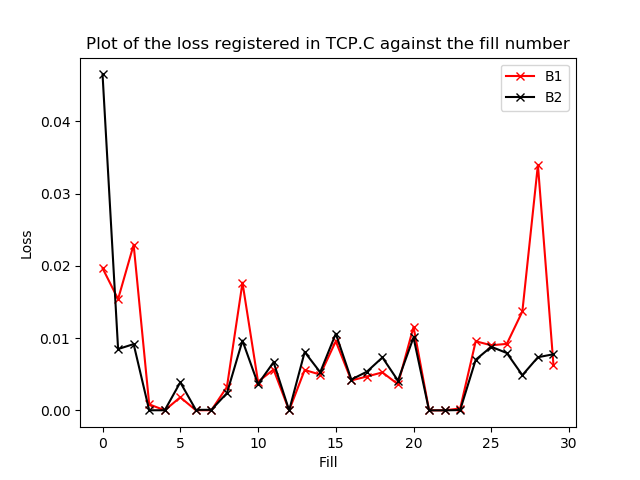

Text(0, 0.5, 'Loss')

In [7]:
# Data
df = pd.DataFrame({
    'B1': mergedBlmData.loc['B1']['BLMTI.06L7.B1E10_TCP.C6L7.B1'],
    'B2': mergedBlmData.loc['B2']['BLMTI.06L7.B1E10_TCP.C6L7.B1']
})
 
# multiple line plot
plt.figure()
plt.plot('B1', data=df, marker='x', color='red')
plt.plot('B2', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of the loss registered in TCP.C against the fill number')
plt.xlabel('Fill')
plt.ylabel('Loss')


<IPython.core.display.Javascript object>


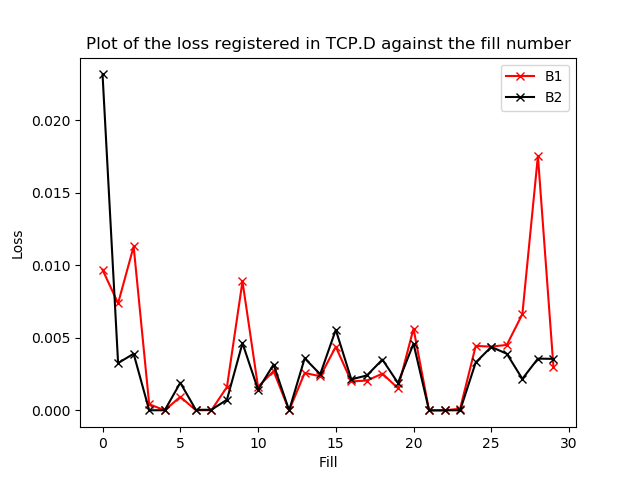

Text(0, 0.5, 'Loss')

In [8]:
# Data
df = pd.DataFrame({
    'B1': mergedBlmData.loc['B1']['BLMTI.06L7.B1E10_TCP.D6L7.B1'],
    'B2': mergedBlmData.loc['B2']['BLMTI.06L7.B1E10_TCP.D6L7.B1']
})

# multiple line plot
plt.figure()
plt.plot('B1', data=df, marker='x', color='red')
plt.plot('B2', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of the loss registered in TCP.D against the fill number')
plt.xlabel('Fill')
plt.ylabel('Loss')

<IPython.core.display.Javascript object>


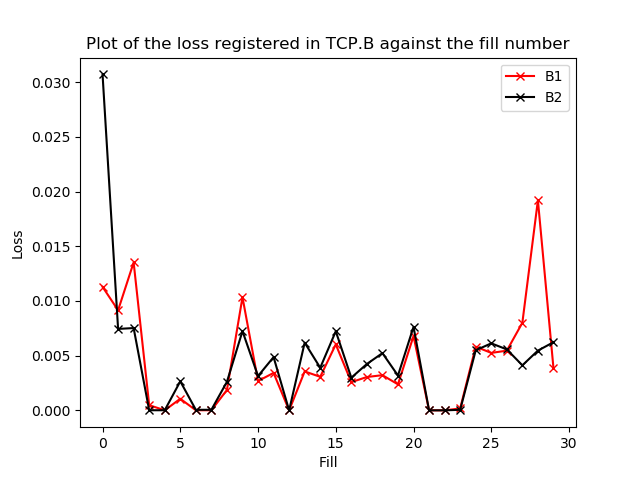

Text(0, 0.5, 'Loss')

In [9]:
# Data
df = pd.DataFrame({
    'B1': mergedBlmData.loc['B1']['BLMTI.06L7.B1E10_TCP.B6L7.B1'],
    'B2': mergedBlmData.loc['B2']['BLMTI.06L7.B1E10_TCP.B6L7.B1']
})
 
# multiple line plot
plt.figure()
plt.plot('B1', data=df, marker='x', color='red')
plt.plot('B2', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of the loss registered in TCP.B against the fill number')
plt.xlabel('Fill')
plt.ylabel('Loss')

<IPython.core.display.Javascript object>


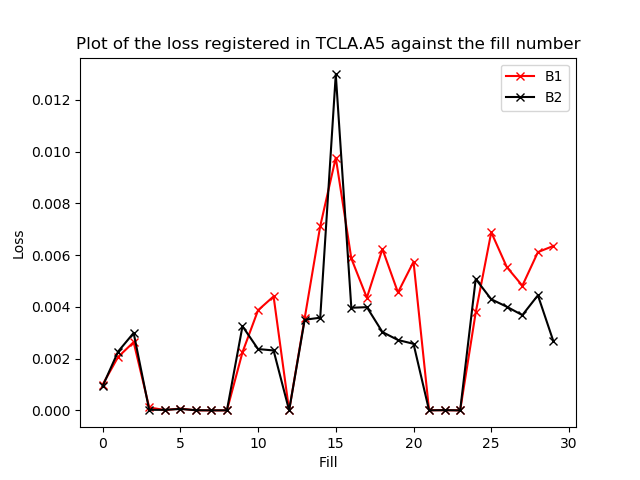

Text(0, 0.5, 'Loss')

In [10]:
# Data
df = pd.DataFrame({
    'B1': mergedBlmData.loc['B1']['BLMTI.05R3.B1I10_TCLA.A5R3.B1'],
    'B2': mergedBlmData.loc['B2']['BLMTI.05R3.B1I10_TCLA.A5R3.B1']
})
 
# multiple line plot
plt.figure()
plt.plot('B1', data=df, marker='x', color='red')
plt.plot('B2', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of the loss registered in TCLA.A5 against the fill number')
plt.xlabel('Fill')
plt.ylabel('Loss')

<IPython.core.display.Javascript object>


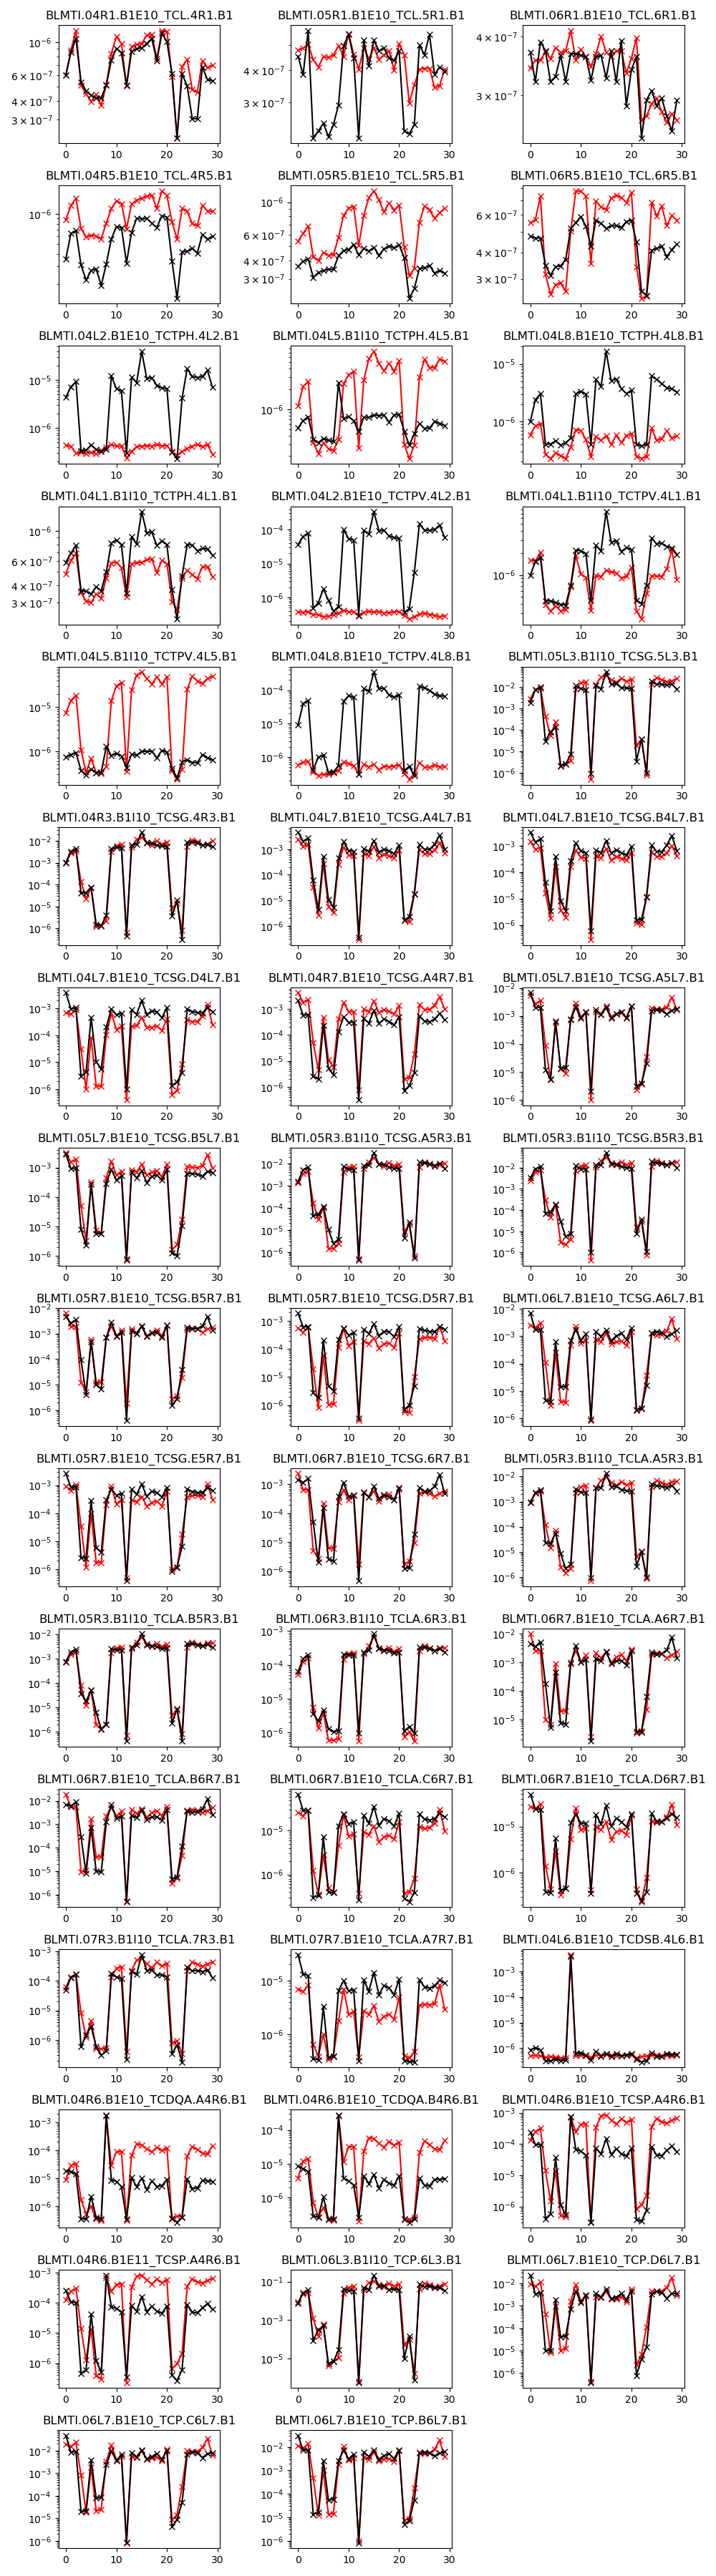

In [25]:
plt.figure(figsize=(10, 36))
ncols = 3;
nrows = math.ceil(mergedBlmData.shape[1] / ncols)
i = 1;

for column in mergedBlmData:
    # Data
    df = pd.DataFrame({
        'B1': mergedBlmData.loc['B1'][column],
        'B2': mergedBlmData.loc['B2'][column]
    })
 
    plt.subplot(nrows, ncols, i)
    plt.yscale('log')
    plt.plot('B1', data=df, marker='x', color='red')
    plt.plot('B2', data=df, marker='x', color='black')
    plt.title(column)

    
    i = i + 1

plt.tight_layout()

In [26]:
# To confirm that plots where values are displayed as zero are not actually zero
print(mergedBlmData.loc['B1']['BLMTI.04L2.B1E10_TCTPH.4L2.B1'])
print(mergedBlmData.loc['B2']['BLMTI.04L2.B1E10_TCTPH.4L2.B1'])
## Data varies by orders of magnitude. Could plot using a log scale

0     4.336000e-07
1     4.143000e-07
2     2.983000e-07
3     3.148000e-07
4     2.955000e-07
5     3.121000e-07
6     2.900000e-07
7     3.425000e-07
8     3.922000e-07
9     4.502000e-07
10    4.198000e-07
11    4.198000e-07
12    2.375000e-07
13    3.259000e-07
14    4.060000e-07
15    4.170000e-07
16    4.281000e-07
17    4.170000e-07
18    4.557000e-07
19    4.198000e-07
20    4.308000e-07
21    3.204000e-07
22    2.679000e-07
23    3.231000e-07
24    3.756000e-07
25    4.170000e-07
26    4.585000e-07
27    4.088000e-07
28    4.502000e-07
29    2.845000e-07
Name: BLMTI.04L2.B1E10_TCTPH.4L2.B1, dtype: float64
0     4.361000e-06
1     7.214000e-06
2     9.222000e-06
3     3.287000e-07
4     3.425000e-07
5     4.419000e-07
6     3.563000e-07
7     3.259000e-07
8     3.618000e-07
9     1.212000e-05
10    6.595000e-06
11    5.894000e-06
12    2.983000e-07
13    1.132000e-05
14    8.835000e-06
15    3.960000e-05
16    1.079000e-05
17    1.112000e-05
18    7.703000e-06
19    6.874000e-0

In [103]:
#To get Euclidean distance between the BLM vectors for beam 1 and beam 2
from scipy.spatial.distance import cdist

distance = cdist(mergedBlmData.loc['B1'].values, mergedBlmData.loc['B2'].values, metric='euclidean').diagonal()
#getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
#eg. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
#row 1 of B2 values, and so on.

#to confirm values are correct:
print(distance)
print(euclidean(mergedBlmData.loc['B1'].iloc[0], mergedBlmData.loc['B2'].iloc[0]))
print(euclidean(mergedBlmData.loc['B1'].iloc[1], mergedBlmData.loc['B2'].iloc[1]))
print(euclidean(mergedBlmData.loc['B1'].iloc[2], mergedBlmData.loc['B2'].iloc[2]))
print(euclidean(mergedBlmData.loc['B1'].iloc[29], mergedBlmData.loc['B2'].iloc[29]))

[3.88557119e-02 9.69606025e-03 2.05050242e-02 1.68188336e-03
 1.72709762e-04 3.08437747e-03 8.93743524e-05 8.84102022e-05
 1.94988529e-03 2.07680826e-02 1.67425268e-02 2.60913906e-02
 2.77477707e-06 1.25410717e-02 5.68120861e-02 1.11747992e-01
 1.48473623e-02 1.01751973e-02 4.73635393e-02 2.02308259e-02
 4.22091069e-02 4.61321262e-05 4.05826838e-05 2.79013725e-04
 3.57796871e-02 3.24884867e-02 1.22174323e-02 1.38117319e-02
 3.64479748e-02 4.86710316e-02]
0.03885571186453924
0.009696060245725066
0.02050502418234528
0.0486710316372905


<IPython.core.display.Javascript object>


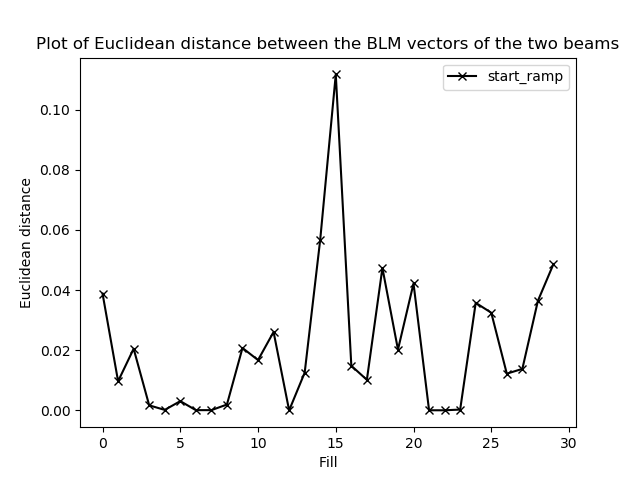

Text(0, 0.5, 'Euclidean distance')

In [105]:
# To plot Euclidean between the vectors (TCP, TCSG, ...) for beam 1 and beam 2
# Data
df = pd.DataFrame({
    'start_ramp': distance
})
 
# multiple line plot
plt.figure()
plt.plot('start_ramp', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of Euclidean distance between the BLM vectors of the two beams')
plt.xlabel('Fill')
plt.ylabel('Euclidean distance')

In [67]:
mergedBlmData.loc['B1'].iloc[0]

BLMTI.04R1.B1E10_TCL.4R1.B1       5.993000e-07
BLMTI.05R1.B1E10_TCL.5R1.B1       4.778000e-07
BLMTI.06R1.B1E10_TCL.6R1.B1       3.425000e-07
BLMTI.04R5.B1E10_TCL.4R5.B1       8.783000e-07
BLMTI.05R5.B1E10_TCL.5R5.B1       5.413000e-07
BLMTI.06R5.B1E10_TCL.6R5.B1       5.496000e-07
BLMTI.04L2.B1E10_TCTPH.4L2.B1     4.336000e-07
BLMTI.04L5.B1I10_TCTPH.4L5.B1     1.124000e-06
BLMTI.04L8.B1E10_TCTPH.4L8.B1     5.855000e-07
BLMTI.04L1.B1I10_TCTPH.4L1.B1     4.861000e-07
BLMTI.04L2.B1E10_TCTPV.4L2.B1     3.756000e-07
BLMTI.04L1.B1I10_TCTPV.4L1.B1     1.594000e-06
BLMTI.04L5.B1I10_TCTPV.4L5.B1     7.358000e-06
BLMTI.04L8.B1E10_TCTPV.4L8.B1     5.745000e-07
BLMTI.05L3.B1I10_TCSG.5L3.B1      2.852000e-03
BLMTI.04R3.B1I10_TCSG.4R3.B1      1.013000e-03
BLMTI.04L7.B1E10_TCSG.A4L7.B1     2.461000e-03
BLMTI.04L7.B1E10_TCSG.B4L7.B1     1.410000e-03
BLMTI.04L7.B1E10_TCSG.D4L7.B1     6.914000e-04
BLMTI.04R7.B1E10_TCSG.A4R7.B1     4.208000e-03
BLMTI.05L7.B1E10_TCSG.A5L7.B1     5.451000e-03
BLMTI.05L7.B1